In [1]:
import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

### Generate the synthetic dataset (same as in [demo.ipynb](https://github.com/ganguli-lab/twpca/blob/master/demo.ipynb)).

In [2]:
from twpca.datasets import jittered_population
from scipy.ndimage import gaussian_filter1d
rates, spikes = jittered_population()
smooth_std = 1.0
data = gaussian_filter1d(spikes, smooth_std, axis=1)

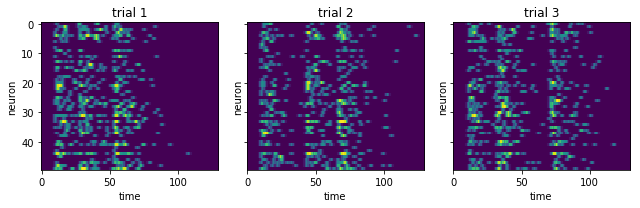

In [3]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9,3))
for ax, trial in zip(axes, data):
    ax.imshow(trial.T, aspect='auto')
    ax.set_xlabel('time')
    ax.set_ylabel('neuron')
[ax.set_title('trial {}'.format(k+1)) for k, ax in enumerate(axes)]
fig.tight_layout()

### We will randomly sample hyperparameters of twPCA using this function

**Note:** Randomly sampling hyperparameters is generally better than doing a search over a pre-specified grid [(Bergstra & Bengio, 2012)](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf).

In [4]:
def sample_hyperparams(n):
    """Randomly draws `n` sets of hyperparameters for twPCA
    """
    n_components = np.random.randint(low=1, high=5, size=n)
    warp_scale = np.random.lognormal(mean=-6, sigma=2, size=n)
    time_scale = np.random.lognormal(mean=-6, sigma=2, size=n) 
    return n_components, warp_scale, time_scale

### Print percentiles to get a sense of the hyperparameter ranges we're sampling

In [5]:
for param in sample_hyperparams(1000):
    pct = np.percentile(param, [0, 25, 50, 75, 100])
    print(('percentiles: ' +
          '0% = {0:.2e}, ' + 
          '25% = {1:.2e}, ' + 
          '50% = {2:.2e}, ' +
          '75% = {3:.2e}, ' + 
          '100% = {4:.2e}').format(*pct))

percentiles: 0% = 1.00e+00, 25% = 2.00e+00, 50% = 3.00e+00, 75% = 3.00e+00, 100% = 4.00e+00
percentiles: 0% = 3.32e-06, 25% = 7.17e-04, 50% = 2.53e-03, 75% = 8.93e-03, 100% = 1.84e+00
percentiles: 0% = 1.15e-05, 25% = 6.12e-04, 50% = 2.43e-03, 75% = 9.62e-03, 100% = 2.14e+00


In [6]:
from twpca.crossval import hyperparam_search

# optimization parameters
fit_kw = {
    'lr': (1e-1, 1e-2),
    'niter': (100, 100),
    'progressbar': False
}

# search 20 sets of hyperparameters
n_components, warp_scales, time_scales = sample_hyperparams(20)

cv_results = hyperparam_search(
                data, # the full dataset
                n_components, warp_scales, time_scales, # hyperparameter arrays
                fit_kw = fit_kw, # parameters passed to optimization routine
            )

100%|██████████| 20/20 [04:12<00:00, 12.07s/it]


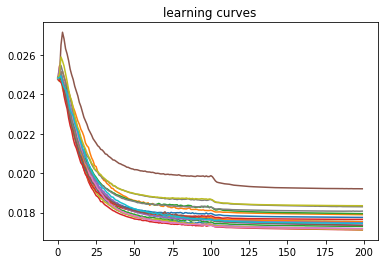

In [7]:
for cv_batch in cv_results['crossval_data']:
    for cv_run in cv_batch:
        plt.plot(cv_run['obj_history'])
plt.title('learning curves')

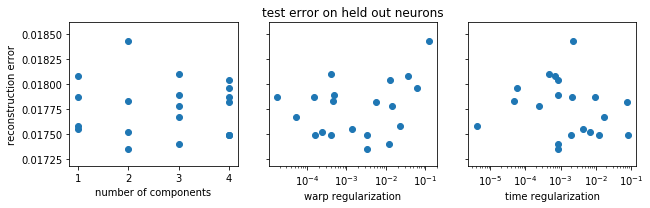

In [8]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(9,3))

axes[0].scatter(cv_results['n_components'], cv_results['mean_test'])
axes[0].set_xticks(np.unique(cv_results['n_components']))
axes[0].set_xlabel('number of components')
axes[0].set_ylabel('reconstruction error')

axes[1].set_xscale('log')
axes[1].scatter(cv_results['warp_scale'], cv_results['mean_test'])
axes[1].set_xlabel('warp regularization')
axes[1].set_title('test error on held out neurons')

axes[2].set_xscale('log')
axes[2].scatter(cv_results['time_scale'], cv_results['mean_test'])
axes[2].set_xlabel('time regularization')

axes[0].set_ylim((min(cv_results['mean_test'])*0.99, max(cv_results['mean_test'])*1.01))
fig.tight_layout()

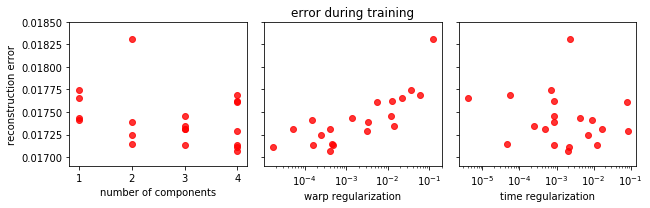

In [9]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(9,3))

axes[0].scatter(cv_results['n_components'], cv_results['mean_train'], color='r', alpha=0.8)
axes[0].set_xticks(np.unique(cv_results['n_components']))
axes[0].set_xlabel('number of components')
axes[0].set_ylabel('reconstruction error')

axes[1].set_xscale('log')
axes[1].scatter(cv_results['warp_scale'], cv_results['mean_train'], color='r', alpha=0.8)
axes[1].set_xlabel('warp regularization')
axes[1].set_title('error during training')

axes[2].set_xscale('log')
axes[2].scatter(cv_results['time_scale'], cv_results['mean_train'], color='r', alpha=0.8)
axes[2].set_xlabel('time regularization')

axes[0].set_ylim((min(cv_results['mean_train'])*0.99, max(cv_results['mean_train'])*1.01))
fig.tight_layout()